Auteur: Michaël Leroy

    + Création graph
        - nodes communes, points de charge, nombre_pdc, puissance_nominale

    + Agent
        - car : battery_capacity, battery_consumption_by_km, battery_level, battery_charge_by_min

    + Parcours:
        - start_city
        - end_city
        - start_bat
        - end_bat        

In [1]:
import os
os.environ['USE_PYGEOS'] = '0'

# Data management
import pandas as pd
import geopandas as gpd
import numpy as np


# Visualisation
import matplotlib.pyplot as plt
import seaborn as sns
import folium
from folium.features import Choropleth
from folium.plugins import MarkerCluster

# Preprocessing
from sklearn.preprocessing import StandardScaler
import umap


# I/O
import gc
import io, requests
import zipfile, shutil
import joblib

# import streamlit as st

# tqdm().pandas()

# data_path = 'C:/Users/demo/Desktop/Lattitude/datas/'
data_path = 'datas'
# os.makedirs(data_path, exist_ok=True)



# def get_datas(file_path, file_name_1, date):
#     parent_path = os.path.dirname(os.getcwd())
#     path_to_datas = os.path.join(parent_path, file_path)

#     # get file catalog and load communes datas at date
#     catalog = joblib.load(os.path.join(path_to_datas, 'file_catalog.joblib'))
#     df= None
#     for file in catalog[date]:
#         if df is None:
#             df = gpd.read_feather(os.path.join(path_to_datas, file))
#         else:
#             df = pd.concat( [df,gpd.read_feather(os.path.join(path_to_datas, file))], axis=0)
            
#     return (
#         gpd.read_feather(os.path.join(path_to_datas, file_name_1)),
#         df
#     )
# bornes, communes = get_datas(data_path,
#                                 'dataset_charge_points.feather',
#                                 '2022-12-31')

token = 'pk.eyJ1IjoibWlrYWxlcm95IiwiYSI6ImNsZzZvcDN4dDBmbXMzZHFmYmd1ajJ6bGIifQ.-GfBZA2ZGXHpkELd0eLBAw'

# Load the data for French garge points
file_name = 'dataset_charge_points.feather'

bornes = gpd.read_feather(os.path.join(data_path, file_name))
bornes = bornes.cx[-5:10, 41:54]
# get x, y from geomerty
bornes['X'] = bornes.geometry.x
bornes['Y'] = bornes.geometry.y
# groupby x,y and take first occurnce
bornes = bornes.groupby(by=['X','Y']).agg('first').reset_index(drop=True)
bornes.dropna( subset='region_name', axis=0, inplace=True)
bornes.reset_index(drop=True, inplace=True)


# Load the data for the communes
file_name = 'dataset_communes.feather'

communes = gpd.read_feather(os.path.join(data_path, file_name))
communes.dropna( subset='region_name', axis=0, inplace=True) 
communes.fillna('n.r.') 
communes = communes.query("date_arrete == '2022-12-31'")
communes.reset_index(drop=True, inplace=True)


In [2]:
bornes.set_crs(communes.crs, inplace=True)

,nom_amenageur,siren_amenageur,contact_amenageur,nom_operateur,contact_operateur,telephone_operateur,nom_enseigne,id_station_itinerance,id_station_local,nom_station,...,consolidated_latitude,consolidated_code_postal,consolidated_commune,consolidated_is_lon_lat_correct,consolidated_is_code_insee_verified,geometry,insee,dep,dep_name,region_name
0,OUEST CHARGE - 29,252901145,david.dorman@sdef.fr,Izivia,sav@izivia.com,0972668001,OUEST CHARGE - 29,FRS29PSD298312,FR*SOD*S*SD29*83*1*_*_,LE CONQUET-PLACE DE BREST,...,48.360584,29217,Le Conquet,True,True,POINT (-4.77022 48.36058),29040,29,Finistère,Bretagne
1,OUEST CHARGE - 29,252901145,david.dorman@sdef.fr,Izivia,sav@izivia.com,0972668001,OUEST CHARGE - 29,FRS29PSD2915612,FR*SOD*S*SD29*156*1*_*_,PORSPODER-RUE DE LEUROPE,...,48.513390,29840,Porspoder,True,True,POINT (-4.76453 48.51339),29221,29,Finistère,Bretagne
2,OUEST CHARGE - 29,252901145,david.dorman@sdef.fr,Izivia,sav@izivia.com,0972668001,OUEST CHARGE - 29,FRS29PSD296511,FR*SOD*S*SD29*65*1*_*_,LAMPAUL PLOUARZEL-RUE DE LA MAIRIE,...,48.448708,29810,Lampaul-Plouarzel,True,True,POINT (-4.76381 48.44871),29098,29,Finistère,Bretagne
3,OUEST CHARGE - 29,252901145,david.dorman@sdef.fr,Izivia,sav@izivia.com,0972668001,OUEST CHARGE - 29,FRS29PSD2921012,FR*SOD*S*SD29*210*1*_*_,LANDUNVEZ - BOULEVARD DE L OCEAN PORT D ARGENTON,...,48.521224,29840,Landunvez,True,True,POINT (-4.75768 48.52122),29109,29,Finistère,Bretagne
4,OUEST CHARGE - 29,252901145,david.dorman@sdef.fr,Izivia,sav@izivia.com,0972668001,OUEST CHARGE - 29,FRS29PSD297511,FR*SOD*S*SD29*75*1*_*_,LANILDUT-ANSE DE SAINT-GILDAS,...,48.474991,29840,Lanildut,True,True,POINT (-4.75049 48.47499),29112,29,Finistère,Bretagne
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17156,"E.Leclerc, San Giuliano",,,Freshmile SAS,web@freshmile.com,0369246732,Freshmile,FRLE2PV7SFAZJTXG,V7SFAZJTXG,"E.Leclerc, San Giuliano",...,42.262915,,,False,False,POINT (9.54739 42.26291),2B303,2B,Haute-Corse,Corse
17157,La Cave d'Aleria,,,Freshmile SAS,web@freshmile.com,0369246732,Freshmile,FRFR1PRBUT3DZJBH,RBUT3DZJBH,"Aleria, La Cave d'Aleria",...,42.114619,,,False,False,POINT (9.55018 42.11462),2B009,2B,Haute-Corse,Corse
17158,Domaine de Riva Bella,,,Freshmile SAS,web@freshmile.com,0369246732,Freshmile,FRFR1PUGFTMLOCNC,UGFTMLOCNC,"Aléria, Domaine de Riva Bella",...,42.160753,,,False,False,POINT (9.55228 42.16075),2B143,2B,Haute-Corse,Corse
17159,Domaine de Riva Bella,,,Freshmile SAS,web@freshmile.com,0369246732,Freshmile,FRFR1PDS2ZKBGWPN,DS2ZKBGWPN,"Aléria, Domaine de Riva Bella, SPA",...,42.157101,,,False,False,POINT (9.55352 42.15710),2B143,2B,Haute-Corse,Corse


In [3]:
bornes.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [4]:
crs = 6171

bornes.to_crs(crs, inplace=True) 
communes.to_crs(crs, inplace=True) 

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 17161 entries, 0 to 17160
Data columns (total 55 columns):
 #   Column                               Non-Null Count  Dtype              
---  ------                               --------------  -----              
 0   nom_amenageur                        17161 non-null  object             
 1   siren_amenageur                      17161 non-null  object             
 2   contact_amenageur                    17161 non-null  object             
 3   nom_operateur                        17161 non-null  object             
 4   contact_operateur                    17161 non-null  object             
 5   telephone_operateur                  17161 non-null  object             
 6   nom_enseigne                         17161 non-null  object             
 7   id_station_itinerance                17161 non-null  object             
 8   id_station_local                     17161 non-null  object             
 9   nom_station         

<AxesSubplot: >

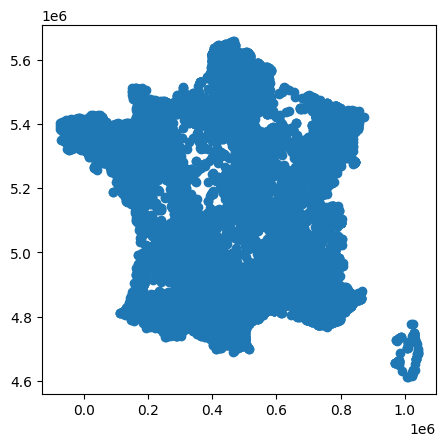

In [5]:
bornes.info()
bornes.plot()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 34821 entries, 0 to 34820
Data columns (total 18 columns):
 #   Column                   Non-Null Count  Dtype   
---  ------                   --------------  -----   
 0   insee                    34821 non-null  object  
 1   nom                      34821 non-null  object  
 2   wikipedia                34817 non-null  object  
 3   surf_ha                  34821 non-null  float64 
 4   geometry                 34821 non-null  geometry
 5   PMUN                     34818 non-null  float64 
 6   PCAP                     34818 non-null  float64 
 7   PTOT                     34818 non-null  float64 
 8   nb_vp                    34821 non-null  float64 
 9   libepci                  34821 non-null  object  
 10  libgeo                   34821 non-null  object  
 11  nb_vp_rechargeables_gaz  34821 non-null  float64 
 12  date_arrete              34821 non-null  object  
 13  epci                     34821 non-null  object  
 14

<AxesSubplot: >

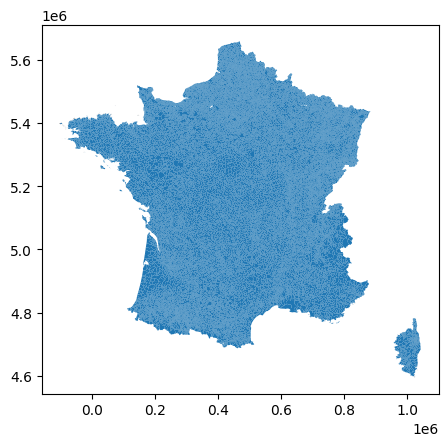

In [6]:
communes.info()
communes.plot()

In [7]:
import networkx as nx
from shapely.geometry import Point, Polygon
from shapely.ops import nearest_points
from mapbox import DirectionsMatrix
import math

# Define the charging station class
class ChargingStation:
    def __init__(self, insee, location, plug_type, charging_power):
        self.insee = insee # string
        self.location = location # shapely point
        self.plug_type = plug_type # string
        self.charging_power = charging_power # float


In [8]:

# Define the function to calculate the distance between two points using the mapbox API
def get_mapbox_distance(start, end):
    directions_matrix = DirectionsMatrix(access_token=token)
    response = directions_matrix.matrix(
        [start],
        [end],
        annotations="distance", # possibility to add duration for a time/distance heuristic
        profile="mapbox/driving",
        sources="all",
        destinations="all",
    )
    distance = response["distances"][0][0]
    return distance


import requests
import json
def get_osrm_distance(poly_start, poly_end):
    url = "http://router.project-osrm.org/route/v1/driving/"
    url += str(poly_start.centroid.y) + "," + str(poly_start.centroid.x) + ";" 
    url += str(poly_end.centroid.y) + "," + str(poly_end.centroid.x)
    # url += "?sources=0&destinations=1"
    # url += "?overview=false&geometries=geojson"
    
    response = requests.get(url)
    if response.status_code != 200:
        raise ValueError(f"Error calculating distances: {response.text}")
    data = response.json()

    return data['waypoints'][0]['distance']

In [9]:
import requests
import json
import requests
import numpy as np

def pre_calculate(polygons, max_batch_size = 3 ):
    
    durations_matrix = []
    distances_matrix = []
    for i in range(0, len(polygons), max_batch_size):
        if i%1000 ==0 : print(i)
        batch_polygons = polygons[i:i+max_batch_size]
        len_batch = len(batch_polygons)
        # Prepare the input for the OSRM table API
        coordinates = ";".join([f"{poly.centroid.y},{poly.centroid.x}" for poly in batch_polygons])
        sources = ";".join([str(i) for i in range(len(batch_polygons))])
        destinations =  ";".join([str(i) for i in range(len(batch_polygons))])

        url = "http://router.project-osrm.org/table/v1/driving/"
        url += coordinates
        url += "?sources=" + sources
        url += "&destinations=" + destinations
        print(url)

        # Send the request to the OSRM table API
        response = requests.get(url)
        if response.status_code != 200:
            raise ValueError(f"Error calculating distances: {response.text}")
        data = response.json()

        # Extract the durations and distances from the response
        durations_matrix += data["durations"]
        distances = []
        for i in range(len_batch):
            distance = data['destinations'][i]['distance']
            distances += [ distance ]

        distances_matrix += [  [ 0 if i==n else distances[(i+n-1)%len_batch] for i in range(len_batch) ]  for n in range(len_batch)]

   # Reshape the distance matrix into a square matrix
    n = int(len(polygons) ** 0.5)
    
    durations = [durations_matrix[i:i+n] for i in range(0, len(distances_matrix), n)]

    distances = [distances_matrix[i:i+n] for i in range(0, len(distances_matrix), n)]


    return durations, distances, durations_matrix, distances_matrix


In [10]:
# Define the function to construct the networkx graph
def construct_graph(cities, charging_stations):
    G = nx.Graph()
    print('Add nodes')
    for i, row in cities.iterrows():
        G.add_node(i, 
                   polygon=row['geometry'], 
                   insee=row['insee'], 
                   charging_stations=[],
                   parent=None
        )

    print('Compute edge distances')
    # Add edges between adjacent polygons
    for i , poly1 in enumerate(cities['geometry']):
        touching = gpd.sjoin(cities, gpd.GeoDataFrame(geometry=[poly1],crs=crs), predicate='touches', how='inner')
        for j in touching.index:
            if i == j:
                continue
            poly2 = touching.loc[j, 'geometry']
            if not G.has_edge(i, j):
                distance_in_meter =poly1.centroid.distance(poly2.centroid)
                G.add_edge(i, j, distance=distance_in_meter / 1e3)
            
    print('Add charging stations')  
    insee_to_idx = dict(zip(cities['insee'],cities.index)) 
    # display(len(insee_to_idx) )
    errors = []    
    for charging_station in charging_stations:
        # print(charging_station.insee)
        try:
            node_idx = insee_to_idx[charging_station.insee]
            G.nodes[node_idx]["charging_stations"] +=[charging_station]
            # print(node_idx,G.nodes[node_idx]["charging_stations"])
        except:
            errors += [charging_station.insee]    
    return G, errors

In [ ]:

# def a_star(G, start_node, end_node, battery_level, consumption_rate):
    # Define heuristic function as distance between nodes' centroids
def heuristic(n1, n2):
    centroid1 = G.nodes[n1]['polygon'].centroid
    centroid2 = G.nodes[n2]['polygon'].centroid
    url = f"https://api.mapbox.com/directions-matrix/v1/mapbox/driving/{centroid1.x},{centroid1.y};{centroid2.x},{centroid2.y}?sources=0&annotations=distance&access_token=YOUR_MAPBOX_ACCESS_TOKEN"
    response = requests.get(url)
    distance = response.json()['distances'][0][1]
    return distance

# No path found



In [ ]:

# Define the function to calculate the heuristic value for A*
def heuristic(node1, node2):
    return math.sqrt((node1.x - node2.x) ** 2 + (node1.y - node2.y) ** 2)



In [ ]:
import networkx as nx
import requests
from shapely.geometry import Point
from shapely.ops import nearest_points


def a_star(G, start, arrival, battery_level, consumption_rate):
    # Define heuristic function as distance between nodes' centroids
    def heuristic(n1, n2):
        centroid1 = G.nodes[n1]['polygon'].centroid
        centroid2 = G.nodes[n2]['polygon'].centroid
        # url = f"https://api.mapbox.com/directions-matrix/v1/mapbox/driving/{centroid1.x},{centroid1.y};{centroid2.x},{centroid2.y}?sources=0&annotations=distance&access_token={token}"
        # response = requests.get(url)
        # distance = response.json()['distances'][0][1]
        distance = math.sqrt((centroid1.x - centroid2.x) ** 2 + (centroid1.y - centroid2.y) ** 2)
        return distance
    
    # Define function to calculate remaining battery level after traveling a given distance
    def remaining_battery_level(battery_level, distance, consumption_rate):
        return battery_level - (distance * consumption_rate)
    


In [11]:
# bornes = bornes.query("dep == '51'").reset_index(drop=True)
charging_stations = [ChargingStation(
                                     insee,
                                     point,
                                     'low' if pwr < 10000 else 'high',
                                     pwr) for insee, point, pwr in zip(bornes['insee'], bornes['geometry'], bornes['puissance_nominale'])
]
                                        

In [12]:
print(charging_stations[0].insee, 
      charging_stations[0].location, 
      charging_stations[0].plug_type, 
      charging_stations[0].charging_power)
len(charging_stations)       

29040 POINT (-75363.77385078068 5385620.656213553) high 22000.0


17161

In [13]:
communes.region_name.unique()

array(['Corse', 'Occitanie', 'Auvergne-Rhône-Alpes',
       "Provence-Alpes-Côte d'Azur", 'Hauts-de-France',
       'Bourgogne-Franche-Comté', 'Île-de-France', 'Centre-Val de Loire',
       'Grand Est', 'Normandie', 'Pays de la Loire', 'Nouvelle-Aquitaine',
       'Bretagne'], dtype=object)

In [14]:
region = 'Grand Est'
com_ = communes.query("region_name == @region").reset_index(drop=True)

try:
    print(f'Load graph  {region} ',end='...')
    G = joblib.load(os.path.join(data_path, f'graph_{region}.pkl'))
    print('Done')
except:
    print(f'no graph file found')
    print(f'Construct graph {region} ',end='...')
    G, errors = construct_graph(com_ , charging_stations)
    print('Done')
    print(len(charging_stations) - len(errors))
    print('Save graph',end='...')
    joblib.dump(G, os.path.join(data_path, f'graph_{region}.pkl'))
    print('Done')

# nx.get_node_attributes(G, 'insee')
# nx.get_node_attributes(G, 'polygon')
# nx.get_node_attributes(G, 'charging_stations')

Load graph  Grand Est ...no graph file found
Construct graph Grand Est ...Add nodes
Compute edge distances
Add charging stations
Done
1284
Save graph...Done


In [ ]:
# nx.get_node_attributes(G, 'insee')
# nx.get_node_attributes(G, 'polygon')
# nx.get_node_attributes(G, 'charging_stations')
# nx.get_node_attributes(G, 'parent')


In [ ]:

# start = Point(0.2, 0.2)

# arrival = Point(2.8, 2.8)




In [ ]:
# def a_star(G, start, end, power_consumption_km, battery_capacity, charge_speed, charge_points=None):
#     """
#     Implements A* search algorithm to find the shortest path between two nodes in a graph.
#     The cost function takes into account the distance between nodes and the energy cost of the path.
    
#     Args:
#         G (nx.Graph): The input graph.
#         start (int): The starting node.
#         end (int): The destination node.
#         power_consumption_km (float): The energy consumption of the vehicle in kWh/km.
#         battery_capacity (float): The capacity of the vehicle's battery in kWh.
#         charge_speed (float): The charging speed of the vehicle in kW.
#         charge_points (list): Optional list of charging points at which the vehicle can recharge.
    
#     Returns:
#         path (list): The shortest path between the start and end nodes.
#         cost (float): The cost of the shortest path.
#     """
#     # Define the heuristic function as the Euclidean distance between nodes
#     def heuristic(node1, node2):
#         return G.nodes[node1]['polygon'].centroid.distance(G.nodes[node2]['polygon'].centroid)
    
#     # Define the cost function as the sum of the distance and energy cost
#     def cost(node1, node2, remaining_battery_level):
#         distance = G.edges[node1, node2]['weight']
#         energy_cost = distance * power_consumption_km
        
#         # If a list of charging points is provided and the battery charge is not sufficient,
#         # add the cost of charging at the nearest charging point
#         if charge_points and remaining_battery_level < energy_cost:
#             nearest_point, charging_time = find_nearest_charging_point(G, node1, charge_points, remaining_battery_level, battery_capacity, charge_speed)
#             distance_to_point = G.edges[node1, nearest_point]['weight']
#             energy_cost = (distance_to_point * power_consumption_km) + ((energy_cost - remaining_battery_level) / battery_capacity) * charging_time
        
#         return distance + energy_cost
    
#     # Initialize the A* algorithm
#     open_set = PriorityQueue()
#     open_set.put((0, start))
#     came_from = {}
#     atempt_score = {start: 0}
#     f_score = {start: heuristic(start, end)}
#     remaining_battery_level = battery_capacity
    
#     # Run the A* algorithm
#     while not open_set.empty():
#         current = open_set.get()[1]
        
#         # Check if the goal has been reached
#         if current == end:
#             path = reconstruct_path(came_from, start, end)
#             cost = atempt_score[current]
#             return path, cost
        
#         # Expand the current node
#         for neighbor in G.neighbors(current):
#             tentative_atempt_score = atempt_score[current] + cost(current, neighbor, remaining_battery_level)
            
#             # Check if the neighbor has been visited before or if a better path has been found
#             if neighbor in atempt_score and tentative_atempt_score >= atempt_score[neighbor]:
#                 continue
                
#             came_from[neighbor] = current
#             atempt_score[neighbor] = tentative_atempt_score
#             f_score[neighbor] = tentative_atempt_score + heuristic(neighbor, end)
#             open_set.put((f_score[neighbor], neighbor))
            
#         # Update the remaining battery level
#         remaining_battery_level -= cost(current, neighbor, remaining_battery_level) / battery_capacity
#         if charge_points and remaining_battery_level < 0:
#             nearest_point, charging_time = find_nearest_charging_point(G, current, charge_points, remaining_battery_level, battery_capacity, charge_speed)
#             # Charge the battery at the nearest charging point
#         remaining_battery_level = min(remaining_battery_level + (charging_time * charge_speed), battery_capacity)
        
#     # If the remaining battery level is negative, there is no feasible path
#     if remaining_battery_level < 0:
#         return None, None
    
#     # If the goal has not been reached, there is no feasible path
#     return None, None


Global travel start node: 3206 | goal node: 4668
Charge needed ! Charge needed ! Charge needed ! Charge needed ! Charge needed ! Charge needed ! Charge needed ! Charge needed ! Charge needed ! Charge needed ! Charge needed ! Charge needed ! Charge needed ! Charge needed ! Charge needed ! Charge needed ! Charge needed ! Charge needed ! Charge needed ! Charge needed ! Charge needed ! Charge needed ! Charge needed ! Charge needed ! Charge needed ! Charge needed ! Charge needed ! Charge needed ! Charge needed ! Charge needed ! Charge needed ! Charge needed ! Charge needed ! Charge needed ! Charge needed ! Charge needed ! Charge needed ! Charge needed ! Charge needed ! Charge needed ! Charge needed ! Charge needed ! Charge needed ! Charge needed ! Charge needed ! Charge needed ! Charge needed ! Charge needed ! Charge needed ! Charge needed ! Charge needed ! Charge needed ! Charge needed ! Charge needed ! Charge needed ! Charge needed ! Charge needed ! Charge needed ! Charge needed ! Charge 

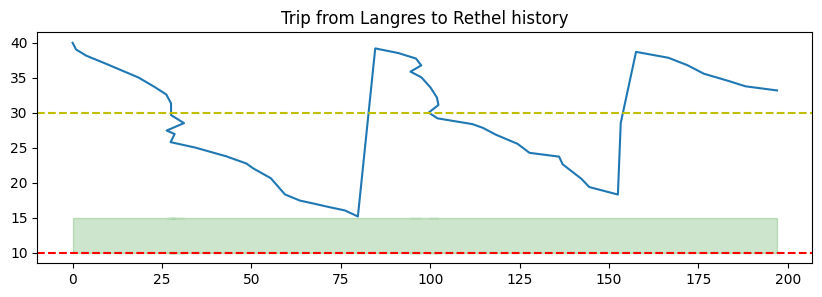

In [109]:
def find_index(graph,start_point, end_point):
    start_polygon_index = None
    arrival_polygon_index = None
    for i in range(len(G.nodes)):
        if G.nodes[i]["polygon"].contains(start_point).any():
            start_polygon_index = i
        if G.nodes[i]["polygon"].contains(end_point).any():
            arrival_polygon_index = i
        if start_polygon_index is not None and arrival_polygon_index is not None:
            break
    if start_polygon_index is None or arrival_polygon_index is None:
        raise ValueError("Start or arrival point is not within any polygon")
    return start_polygon_index, arrival_polygon_index




def a_star(graph, start, goal, charge_time, min_admissible_battery_level, optimal_charge_level_max, desired_goal_battery_level, battery_capacity, charge_speed, consumption_rate, battery_current_charge):
    """
    Find the lowest cost path from `start` to `goal` using A* algorithm.

    Parameters:
        graph (networkx.Graph): The graph to search.
        start (shapely Point): The starting Point.
        goal (shapely Point): The goal Point.
        battery_capacity (float): The maximum battery capacity in kWh.
        charge_speed (float): The charging speed in kWh per hour.
        consumption_rate (float): The energy consumption rate in kWh per km.

    Returns:
        path (list): The path from `start` to `goal`.
        cost (float): The cost of the path.
    """
    
    # find the index of the start and goal
    # start, goal = find_index(graph, start, goal)
    # print(f'Start node: {start} | Goal node: {goal}')

    # Initialize the data structures
    explored = set()
    dist_scores = {start: 0}
    chrg_time_scores = {start: 0}
    distance_to_goal = lambda node: graph.nodes[node]['polygon'].centroid.distance(graph.nodes[goal]['polygon'].centroid)
    optimal = lambda level : level >= min_admissible_battery_level and level <= optimal_charge_level_max

    dist_goal_scores = {start: distance_to_goal(start) / 1e3 - dist_scores[start] }
    bat_goal_level = {start: battery_current_charge - dist_goal_scores[start] / 1e3 * consumption_rate}
    global_scores = {start: dist_goal_scores[start] + dist_scores[start]}
    battery_levels = {start: battery_current_charge}

    # Estimate if the desired_goal_battery_level is reached without charging
    needed_energy = dist_goal_scores[start] * consumption_rate

    # Define the heuristic function as the Euclidean distance between nodes
    def heuristic(idx_node1, idx_node2):
        # dist = graph.nodes[idx_node1]['polygon'].centroid.distance(graph.nodes[idx_node2]['polygon'].centroid)
        # node1 = graph.nodes[idx_node1]['polygon'].centroid; node2=graph.nodes[idx_node2]['polygon'].centroid; dist = math.sqrt((node1.x - node2.x) ** 2 + (node1.y - node2.y) ** 2)
        dist = graph[idx_node1][idx_node2]['distance']
        return  dist
    
    # Find nearest charging point
    def find_best_charging_option(node, next_node):
        print('Charge needed !', end=' ')
        node_position = graph.nodes[node]['polygon'].centroid
        next_node_position = graph.nodes[next_node]['polygon'].centroid
        charge_points = [] + graph.nodes[node]['charging_stations'] + graph.nodes[next_node]['charging_stations']
        if len(charge_points):
            print(f'neigbourhood charging stations: {charge_points}')
        power ={}
        dist_charge = {}
        charge_score = {}
        # charge_dist_to_next = {}
        #TOD0 with different charge_time on each charge point try to recursively finish travel
        if charge_points == []:
            return 0, 0, 0, 0
        else:
            for i, station in enumerate(charge_points):
                node_to_station = node_position.distance(station.location)
                station_to_next = next_node_position.distance(station.location)
                power[i] = station.charging_power * charge_time
                dist_charge[i] = (node_to_station + station_to_next) / 1e3
                charge_score[i] = power[i] / dist_charge[i]
            best_choice = max(charge_score, key=charge_score.get)
            print(f'{power}/{dist_charge}/{charge_score}-best choice: {best_choice}')
            time = charge_time
            
            pwr = power[best_choice]
            dist_charge = dist_charge[best_choice]
            return time, pwr, dist_charge, dist_charge * consumption_rate 

# Define the cost function as distance, energy and charging time cost
    def cost(node1, node2 ):
        distance = heuristic(node1, node2)
        energy_cost = distance * consumption_rate
        
        return distance , energy_cost

    # The main loop
    iteration = 0
    while global_scores:
        # print('iteration: ', iteration)
        # print(battery_levels)

        # Select the node with the lowest f_score
        current = min(global_scores, key=global_scores.get)

        # Check if the goal has been reached
        if current == goal:
            path = [current]
            battery = [battery_levels[current]]
            distance = [dist_goal_scores[start]]
            time = [chrg_time_scores[current]]
            cost = dist_scores[current]
            while current in graph.nodes and graph.nodes[current]['parent'] is not None:
                current = graph.nodes[current]['parent']         ###### graph.parent[current]
                path.append(current)
                battery.append(battery_levels[current])
                distance.append( dist_goal_scores[start] - dist_goal_scores[current] )
                time.append(chrg_time_scores[current])
                
            path.reverse()
            battery.reverse()
            time.reverse()
            return path, battery, distance, time, cost

        # Update the data structures
        del global_scores[current]
        explored.add(current)

        # Iterate over the neighbors of the current node
        voisins = [id for id in graph.neighbors(current)]
        for neighbor in graph.neighbors(current):
            voisins.remove(neighbor)
            charge_flag = False
            # Check if the neighbor has been explored
            if neighbor in explored:
                continue

            # Calculate the tentative atempt_score for the neighbor
            try_dist , try_nrg = cost(current,neighbor)
            atempt_score = 0.5 * try_dist + 0.5 * try_nrg #dist_scores[current] + distance / (1 - battery_levels[current] / battery_capacity * consumption_rate)

            # Check if the neighbor has been visited before
            if neighbor not in global_scores:
                # Add the neighbor to the frontier
                battery_levels[neighbor] = battery_levels[current] - try_nrg
                bat_goal_level[neighbor] = battery_levels[neighbor] - distance_to_goal(neighbor) / 1e3 * consumption_rate

                if bat_goal_level[neighbor] < desired_goal_battery_level and ( optimal(battery_levels[neighbor]) or distance_to_goal(neighbor) / 1e3 <= 30 ) :
                    time, pwr, detour, detour_nrg = find_best_charging_option(current, neighbor)
                    if (time, pwr, detour, detour_nrg) != (0,0,0,0):
                        charge_flag = True
                        battery_levels[neighbor] = battery_levels[current] + pwr - detour_nrg
                        atempt_score = 0.5 * detour + 0.5 * detour_nrg
                    else:
                        continue  # Not enough battery to reach the neighbor
                dist_score = distance_to_goal(neighbor) / 1e3    #graph.nodes[neighbor]['distance_to_goal']
                score = dist_score - atempt_score    #time_to_arrive + dist_score
                
                global_scores[neighbor] = score
                dist_scores[neighbor] = atempt_score
                dist_goal_scores[neighbor] =  distance_to_goal(neighbor) / 1e3 - dist_scores[neighbor] 
                
                chrg_time_scores[neighbor] = time if charge_flag else 0
                graph.nodes[neighbor]['parent'] = current
            else:
                # Check if the new path is better than the previous one
                battery_levels[neighbor] = battery_levels[current] - try_nrg
                bat_goal_level[neighbor] = battery_levels[neighbor] - distance_to_goal(neighbor) / 1e3 * consumption_rate

                if bat_goal_level[neighbor] < desired_goal_battery_level and ( optimal(battery_levels[neighbor]) or distance_to_goal(neighbor) / 1e3 <= 30 ):
                    time, pwr, detour, detour_nrg = find_best_charging_option(current, neighbor)
                    if (time, pwr, detour, detour_nrg) != (0,0,0,0):
                        charge_flag = True
                        battery_levels[neighbor] = battery_levels[current] + pwr - detour_nrg
                        atempt_score = 0.5 * detour + 0.5 * detour_nrg
                    else:
                        continue  # Not enough battery to reach the neighbor
                dist_score = distance_to_goal(neighbor) / 1e3    #graph.nodes[neighbor]['distance_to_goal']
                score = dist_score - atempt_score
                if score >= dist_scores[neighbor]:
                    continue  # The previous path is better
                global_scores[neighbor] = score
                dist_scores[neighbor] = atempt_score
                dist_goal_scores[neighbor] =  distance_to_goal(neighbor) / 1e3 - dist_scores[neighbor]
                chrg_time_scores[neighbor] = time if charge_flag else 0
                graph.nodes[neighbor]['parent'] = current
        iteration += 1

    # No feasible path found
    return None, None, None, None, float('inf')




start_city = 'Langres'
goal_city = 'Rethel'

battery_capacity = 60
charge_speed= 10
consumption_rate = 17/100
battery_current_charge = 40
min_admissible_battery_level = 10
optimal_charge_level_max = 15
desired_goal_battery_level = 30
max_charge_time = 0.5

# Get centroids of start and goal cities
start_point = com_.query("nom == @start_city").centroid.values
goal_point = com_.query("nom == @goal_city").centroid.values

 # find the index of the start and goal
start, goal = find_index(G, start_point, goal_point)
print(f'Global travel start node: {start} | goal node: {goal}')

path, battery, distance, time, cost = a_star(G, start, goal, max_charge_time, min_admissible_battery_level, optimal_charge_level_max, desired_goal_battery_level, battery_capacity, charge_speed, consumption_rate, battery_current_charge)

# Print the result
if path is not None:
    print(f"Optimal path: {path}")
    print(f"Battery path: {battery}")
    print(f"Distance path: {distance}")
    print(f"Times   path: {time}")

    print(f"Cost: {cost:.4f}")
else:
    print("No feasible path found")
run = pd.DataFrame([path, battery, distance, time], index=['path', 'battery', 'distance', 'time']).T
run['parcours'] = run.distance.max() - run.distance
run.head(1)

plt.plot(run.parcours, run.battery)
plt.axhline(min_admissible_battery_level, color='r',  linestyle='--')
plt.axhline(desired_goal_battery_level, color='y',  linestyle='--')

plt.fill_between(run.parcours, min_admissible_battery_level, optimal_charge_level_max, color='g', alpha=0.2)
plt.gcf().set_size_inches(10,3)
plt.gca().set_title(f'Trip from {start_city} to {goal_city} history')
plt.show()